## Loading the data & cleaning (if necessary)

# **Spotify Popularity Prediction**

 By: Chad Rivera, Cheng Wu, Kyle Kirejczyk

## Import all the libraries

In [ ]:

#importing everything from the hw's 
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import statistics
import pandas as pd
import seaborn as sns
import statsmodels.api as sm 
from ISLP import load_data
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#from sklearn.preprocessing import StandardScale
import random   
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


## Loading the data & cleaning (if necessary)

In [2]:
#import everything
df = pd.read_csv("top_10000_1950-now.csv")

# Drop irrelevant columns (IDs, names, etc.)
drop_cols = [
    'Track URI', 'Track Name', 'Artist URI(s)', 'Artist Name(s)', 
    'Album URI', 'Album Name', 'Album Artist URI(s)', 'Album Artist Name(s)',
    'Album Release Date', 'Album Image URL', 'Track Preview URL', 
    'ISRC', 'Added By', 'Added At', 'Label', 'Copyrights', 
    "Artist Genres", "Album Genres", "Disc Number", "Track Number"
]



df = df.drop(columns=[col for col in drop_cols if col in df.columns])


# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Mode', 'Explicit'], drop_first=True)

# Drop any rows with missing values
df = df.dropna()

# Convert 'Track Duration (ms)' to minutes
df['Track Duration (min)'] = df['Track Duration (ms)'] / 60000  # Convert from milliseconds to minutes

# Separate features and target variable
X = df.drop(columns=['Popularity', 'Track Duration (ms)'])  # Dropping original duration column
y = df['Popularity']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(df.head())

   Track Duration (ms)  Popularity  Danceability  Energy   Key  Loudness  \
0               192373           0         0.532   0.760  11.0    -7.123   
1               152160          54         0.703   0.478   7.0    -8.062   
2               197933          63         0.664   0.714   7.0    -6.645   
3               238413          39         0.543   0.808   9.0    -6.615   
4               163586          35         0.664   0.585   0.0    -7.062   

   Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo  \
0       0.0353      0.000101          0.690000    0.0752    0.158  134.974   
1       0.0441      0.626000          0.000000    0.1130    0.734  117.562   
2       0.1110      0.035300          0.000008    0.0843    0.710  101.969   
3       0.0632      0.042900          0.000002    0.3260    0.299  140.064   
4       0.0248      0.624000          0.000112    0.3430    0.597  111.290   

   Time Signature  Mode_1.0  Explicit_True  Track Duration (min)  
0      


📌 Lasso Selected Features (13):
['Danceability', 'Energy', 'Key', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature', 'Mode_1.0', 'Explicit_True', 'Track Duration (min)']

📈 Random Forest Results (Lasso-selected features):
R²: -0.035
RMSE: 27.87


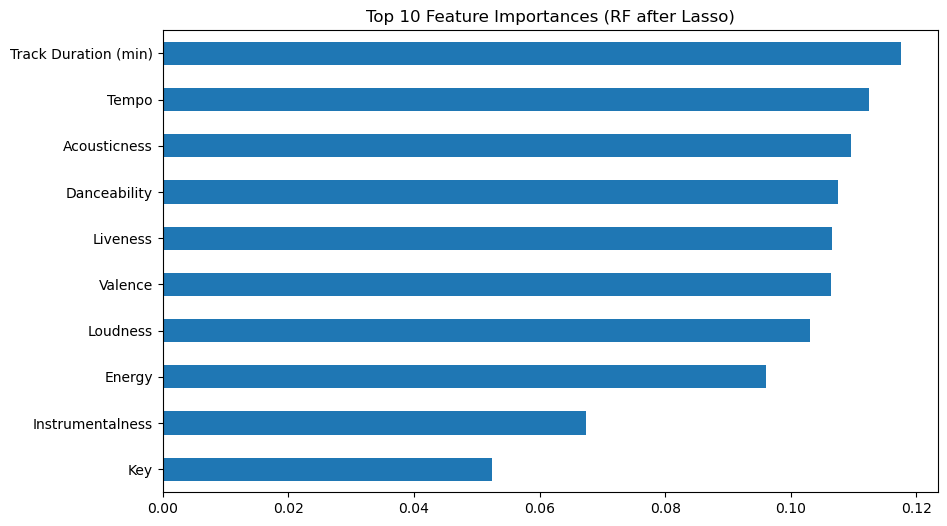

In [3]:
# 2. Run Lasso for feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract selected features
lasso_selected = X.columns[lasso.coef_ != 0]
print(f"\n📌 Lasso Selected Features ({len(lasso_selected)}):")
print(list(lasso_selected))

# Subset the original (unscaled) data with selected features for tree-based models
X_lasso_selected = X[lasso_selected]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lasso_selected, y, test_size=0.2, random_state=42)

# 3. Train Random Forest using only Lasso-selected features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n📈 Random Forest Results (Lasso-selected features):")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# 4. Plot top feature importances
importances = pd.Series(rf.feature_importances_, index=lasso_selected)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_features.plot(kind='barh')
plt.title("Top 10 Feature Importances (RF after Lasso)")
plt.gca().invert_yaxis()
plt.show()

## Partition Data

In [4]:
# Fit Lasso model with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Predict on test set
y_pred_lasso = lasso.predict(X_test)

# Evaluation
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

print(f"Lasso R²: {r2_lasso:.3f}")
print(f"Lasso RMSE: {rmse_lasso:.3f}")

# Feature importances (non-zero coefficients)
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
lasso_coef = lasso_coef[lasso_coef != 0].sort_values(key=abs, ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
lasso_coef.head(10).plot(kind='barh')
plt.title("Top 10 Lasso Regression Features")
plt.gca().invert_yaxis()
plt.show()

TypeError: got an unexpected keyword argument 'squared'


📌 Lasso Selected Features (13):
['Danceability', 'Energy', 'Key', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature', 'Mode_1.0', 'Explicit_True', 'Track Duration (min)']

📈 Random Forest Results (Lasso-selected features):
R²: -0.037
RMSE: 27.89


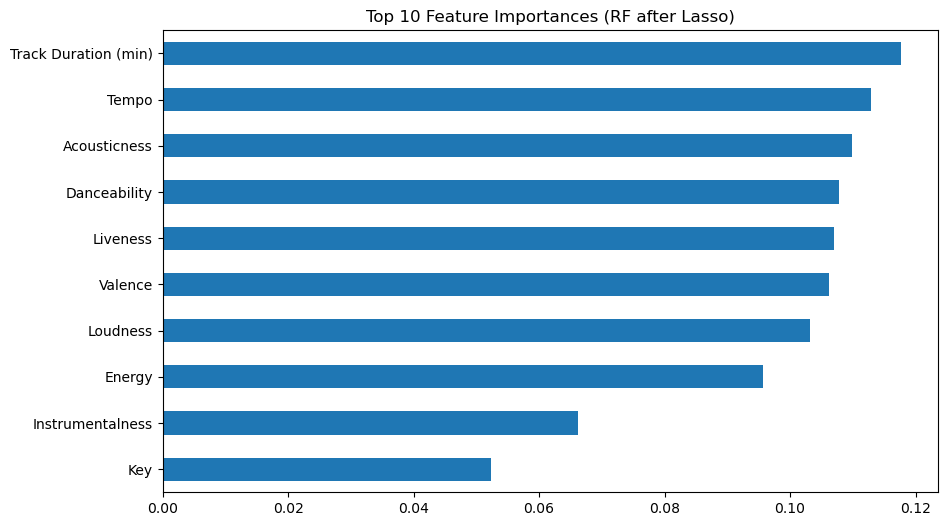

In [ ]:

# 2. Run Lasso for feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract selected features
lasso_selected = X.columns[lasso.coef_ != 0]
print(f"\n📌 Lasso Selected Features ({len(lasso_selected)}):")
print(list(lasso_selected))

# Subset the original (unscaled) data with selected features for tree-based models
X_lasso_selected = X[lasso_selected]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lasso_selected, y, test_size=0.2, random_state=42)

# 3. Train Random Forest using only Lasso-selected features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n📈 Random Forest Results (Lasso-selected features):")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# 4. Plot top feature importances
importances = pd.Series(rf.feature_importances_, index=lasso_selected)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_features.plot(kind='barh')
plt.title("Top 10 Feature Importances (RF after Lasso)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
print(f"🔍 Lasso R²:  {r2_lasso:.3f}, RMSE: {rmse_lasso:.3f}")
print(f"🌲 RF    R²:  {r2_rf:.3f}, RMSE: {rmse_rf:.3f}")

🔍 Lasso R²:  0.012, RMSE: 27.233
🌲 RF    R²:  -0.036, RMSE: 27.882


Lasso R2: 0.012, RMSE: 27.233
Random Forest R2: -0.033, RMSE: 27.846
Top 5 important features from Random Forest:
Track Duration (min)    0.104709
Acousticness            0.100860
Tempo                   0.100195
Danceability            0.099237
Valence                 0.095922
dtype: float64
Average values for popular songs:
Track Duration (min)      3.756282
Acousticness              0.186553
Tempo                   120.004191
Danceability              0.632450
Valence                   0.568550
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


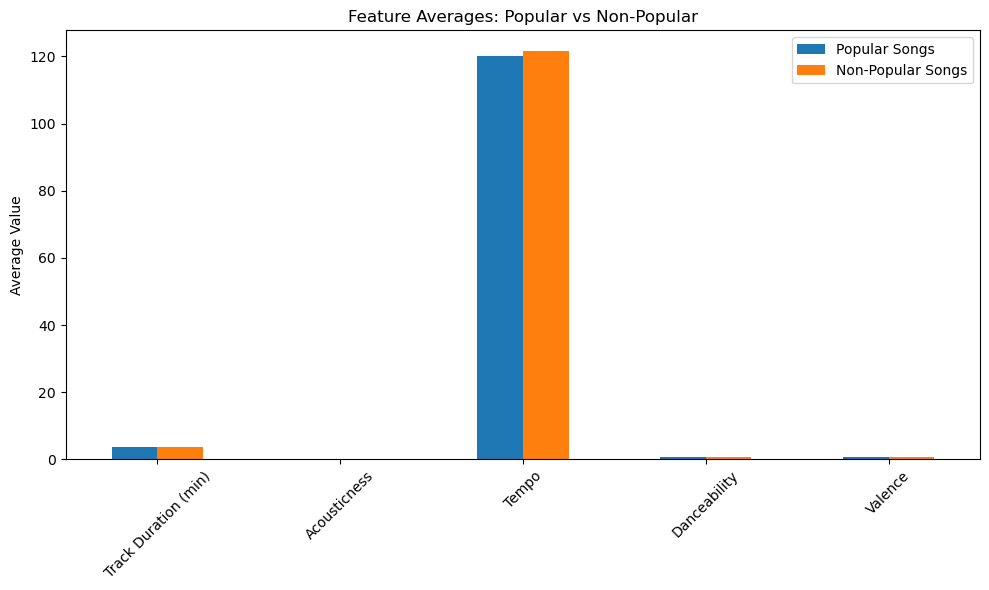

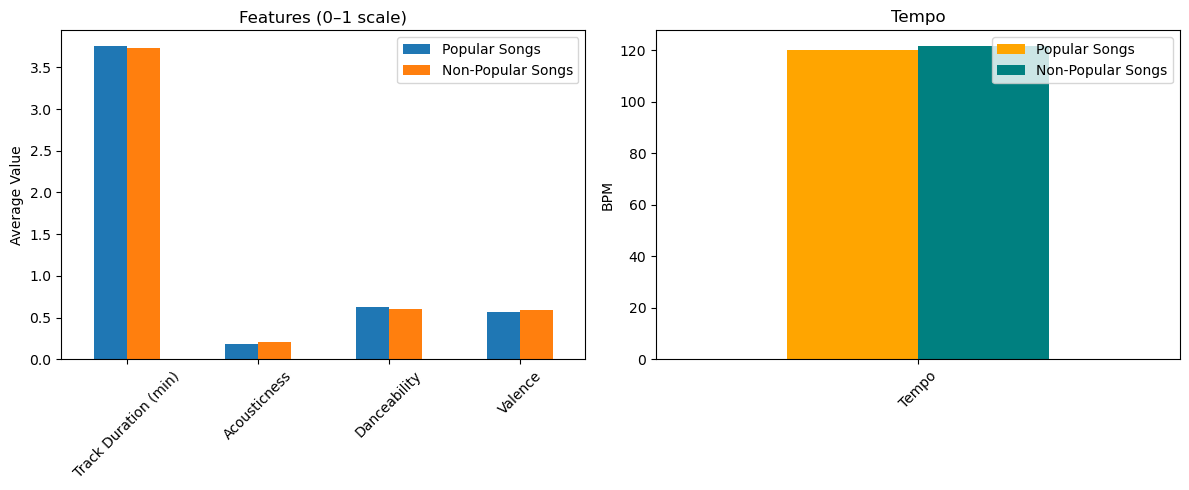

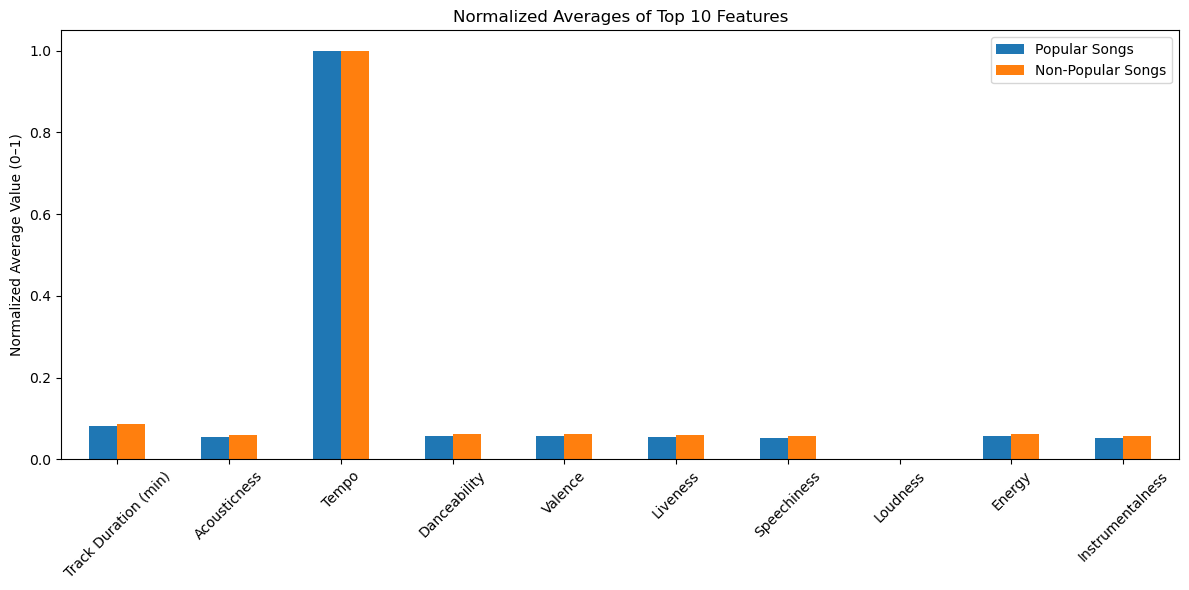

Average Values for Top Features (Popular vs Non-Popular Songs):

                      Popular Avg  Non-Popular Avg  \
Track Duration (min)        3.756            3.734   
Acousticness                0.187            0.211   
Tempo                     120.004          121.705   
Danceability                0.632            0.606   
Valence                     0.569            0.588   
Liveness                    0.173            0.187   
Speechiness                 0.071            0.064   
Loudness                   -6.596           -7.327   
Energy                      0.688            0.684   
Instrumentalness            0.016            0.031   

                      Difference (Popular - Non-Popular)  
Track Duration (min)                               0.022  
Acousticness                                      -0.024  
Tempo                                             -1.701  
Danceability                                       0.027  
Valence                                      

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Train Lasso Regression (with cross-validation)
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)

# Step 4: Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Step 5: Evaluate the models

# Lasso Evaluation
y_pred_lasso = lasso.predict(X_test)
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)  # Update RMSE calculation

# Random Forest Evaluation
y_pred_rf = rf.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)  # Update RMSE calculation

print(f"Lasso R2: {lasso_r2:.3f}, RMSE: {lasso_rmse:.3f}")
print(f"Random Forest R2: {rf_r2:.3f}, RMSE: {rf_rmse:.3f}")

# Step 6: Feature Importance from Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 5 important features from Random Forest:")
print(rf_importances.head())

# Step 7: Calculate Average Values for Popular Songs (Popularity >= 70)
top_features = rf_importances.head(5).index  # Get top 5 features from Random Forest

# Define popular songs as those with popularity >= 70
popular_songs = df[df['Popularity'] >= 70]

# Calculate the average values of the top features for popular songs
popular_avg = popular_songs[top_features].mean()
print("Average values for popular songs:")
print(popular_avg)

# Step 8: Compare with Non-Popular Songs (Popularity < 70)
non_popular_songs = df[df['Popularity'] < 70]
non_popular_avg = non_popular_songs[top_features].mean()

# Step 9: Plot the comparison between Popular and Non-Popular songs for the top features
comparison = pd.DataFrame({
    'Popular Songs': popular_avg,
    'Non-Popular Songs': non_popular_avg
})
comparison.plot(kind='bar', figsize=(10,6), title='Feature Averages: Popular vs Non-Popular')
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot smaller-scale features
small_scale = ['Track Duration (min)', 'Acousticness', 'Danceability', 'Valence']
comparison.loc[small_scale].plot(kind='bar', ax=ax[0])
ax[0].set_title("Features (0–1 scale)")
ax[0].set_ylabel("Average Value")
ax[0].tick_params(axis='x', rotation=45)

# Plot Tempo separately
comparison.loc[['Tempo']].plot(kind='bar', ax=ax[1], color=['orange', 'teal'])
ax[1].set_title("Tempo")
ax[1].set_ylabel("BPM")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




# Step 1: Get top N important features from Random Forest
top_n = 10
top_features = rf_importances.head(top_n).index

# Step 2: Subset the data to those features and split by popularity
popular_songs = df[df['Popularity'] >= 70]
non_popular_songs = df[df['Popularity'] < 70]

# Step 3: Calculate average values for both groups
popular_avg = popular_songs[top_features].mean()
non_popular_avg = non_popular_songs[top_features].mean()

# Step 4: Create comparison DataFrame
comparison = pd.DataFrame({
    'Popular Songs': popular_avg,
    'Non-Popular Songs': non_popular_avg
})

# Step 5: Normalize the values for visualization (min-max scaling)
comparison_normalized = (comparison - comparison.min()) / (comparison.max() - comparison.min())

# Step 6: Plot
comparison_normalized.plot(kind='bar', figsize=(12, 6), title=f'Normalized Averages of Top {top_n} Features')
plt.ylabel("Normalized Average Value (0–1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import pandas as pd

# Set threshold for popularity (adjust if needed)
popularity_threshold = 70

# Top N features based on Random Forest importances
top_features = rf_importances.head(10).index.tolist()

# Split dataset
popular_songs = df[df['Popularity'] >= popularity_threshold]
non_popular_songs = df[df['Popularity'] < popularity_threshold]

# Calculate averages
popular_avg = popular_songs[top_features].mean()
non_popular_avg = non_popular_songs[top_features].mean()

# Combine into single DataFrame
comparison_table = pd.DataFrame({
    'Popular Avg': popular_avg,
    'Non-Popular Avg': non_popular_avg,
    'Difference (Popular - Non-Popular)': popular_avg - non_popular_avg
})

# Optional: round for readability
comparison_table = comparison_table.round(3)

# Print the result
print("Average Values for Top Features (Popular vs Non-Popular Songs):\n")
print(comparison_table)